In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
import glob
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
from torch.utils.data import Dataset
import random

In [3]:
import matplotlib.pyplot as plt
import os
import sys
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
torchvision.__version__, torch.__version__ # ('0.11.2+cu102', '1.10.1+cu102')

('0.12.0', '1.11.0')

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 42
seed_everything(seed)

In [6]:
device = 'cuda'

In [7]:
train_dir = '../input/iais22-birds/birds/birds'

In [8]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [9]:
train_list = []
classes = get_classes(train_dir)
for c in classes:
    train_list = train_list + (glob.glob(os.path.join(train_dir+"/"+c,'*.jpg')))

print(f"Train Data: {len(train_list)}")

Train Data: 58388


In [10]:
labels = [path.split('/')[-2] for path in train_list]

In [11]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

labels2 = [path.split('/')[-2] for path in valid_list]

test_list, valid_list = train_test_split(valid_list, 
                                          test_size=0.2,
                                          stratify=labels2,
                                          random_state=seed)

In [12]:
class BirdsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-2]
        label = classes.index(label)

        return img_transformed, label

In [13]:
def get_data_loaders(data_dir, batch_size=64, train = False):
    if train:
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(), 
                                                        transforms.GaussianBlur(3)]), p=0.1),
            transforms.Resize(256),
            transforms.CenterCrop(240),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.RandomErasing(p=0.14, value='random')
        ])
        train_data = BirdsDataset(train_list, transform=transform)
        #print(f"Found {len(train_data)} images for training with {len(train_data.classes)} classes")
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        return train_loader, len(train_data)
    
    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(240),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        val_data = BirdsDataset(valid_list, transform=transform)
        test_data = datasets.ImageFolder("../input/iais22-birds/birds/birds", transform=transform)
        #print(f"Found {len(val_data)} images for validation with {len(val_data.classes)} classes")
        #print(f"Found {len(test_data)} images for testing with {len(test_data.classes)} classes")
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)
        return (val_loader, test_loader, len(val_data), len(test_data))

In [14]:
(train_loader, train_data_len) = get_data_loaders("../input/iais22-birds", 256, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders("../input/iais22-birds", 64, train=False)

In [15]:
dataloaders = {
    "train":train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train":train_data_len,
    "val": valid_data_len
}

In [16]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

183
37
913


In [17]:
print(train_data_len, test_data_len, valid_data_len)

46710 58388 2336


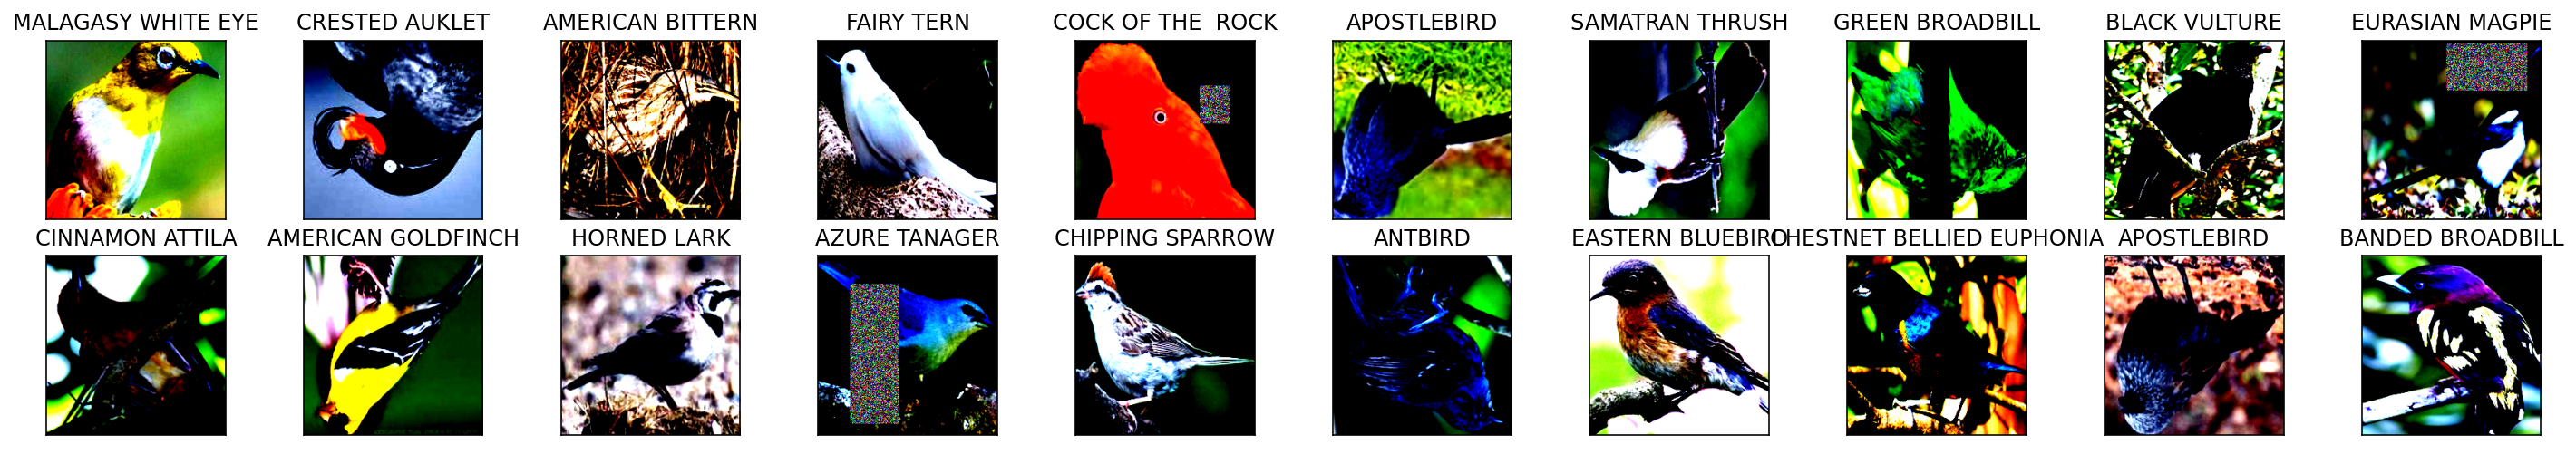

In [18]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
## EFFICIENTNET B0
torch.backends.cudnn.benchmark = True
model = models.efficientnet_b1(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
n_inputs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(n_inputs,2048),
    nn.SiLU(),
    nn.Dropout(0.2),
    nn.Linear(2048, len(classes))
)

model = model.to(device)
print(model.classifier)

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-533bc792.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=2048, out_features=400, bias=True)
)


In [21]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.11)
criterion = criterion.to(device)
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)

In [22]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [23]:
from tqdm import tqdm
import time
import copy

In [24]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [26]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------


100%|██████████| 183/183 [04:18<00:00,  1.41s/it]


train Loss: 3.0503 Acc: 0.5702


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


val Loss: 1.8912 Acc: 0.8395

Epoch 1/1
----------


100%|██████████| 183/183 [03:25<00:00,  1.12s/it]


train Loss: 1.9807 Acc: 0.8094


100%|██████████| 37/37 [00:09<00:00,  4.09it/s]

val Loss: 1.7240 Acc: 0.8711

Training complete in 8m 5s
Best val Acc: 0.871147


In [27]:
def test(model):
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  model.eval()

  for data, target in tqdm(test_loader):
      if torch.cuda.is_available(): 
          data, target = data.cuda(), target.cuda()
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      if len(target) == 64:
        for i in range(64):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(classes)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [28]:
test(model_ft)

100%|██████████| 913/913 [03:55<00:00,  3.87it/s]

Test Loss: 1.602719

Test Accuracy of ABBOTTS BABBLER: 90% (151/166)
Test Accuracy of ABBOTTS BOOBY: 88% (160/180)
Test Accuracy of ABYSSINIAN GROUND HORNBILL: 93% (168/179)
Test Accuracy of AFRICAN CROWNED CRANE: 99% (136/137)
Test Accuracy of AFRICAN EMERALD CUCKOO: 84% (124/146)
Test Accuracy of AFRICAN FIREFINCH: 82% (113/137)
Test Accuracy of AFRICAN OYSTER CATCHER: 89% (116/130)
Test Accuracy of ALBATROSS: 87% (116/133)
Test Accuracy of ALBERTS TOWHEE: 85% (138/161)
Test Accuracy of ALEXANDRINE PARAKEET: 96% (160/165)
Test Accuracy of ALPINE CHOUGH: 91% (152/166)
Test Accuracy of ALTAMIRA YELLOWTHROAT: 75% (93/124)
Test Accuracy of AMERICAN AVOCET: 98% (176/179)
Test Accuracy of AMERICAN BITTERN: 99% (169/170)
Test Accuracy of AMERICAN COOT: 96% (152/158)
Test Accuracy of AMERICAN GOLDFINCH: 93% (125/133)
Test Accuracy of AMERICAN KESTREL: 95% (124/130)
Test Accuracy of AMERICAN PIPIT: 98% (176/179)
Test Accuracy of AMERICAN REDSTART: 91% (127/139)
Test Accuracy of AMETHYST WOODS

In [ ]:
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model_ft.cpu(), example)
traced_script_module.save("birds-325-efficientnetb1.zip")